# NLP_GoingDeeper | E05.Transformer
- 현재까지도 각종 번역 부문에서 최고의 성능을 자랑하는 **트랜스포머 모델**을 활용하여 번역기를 만들어봅니다. 

---
- 대부분의 sequence를 다루는 모델들은 encoder-decoder 구조로 되어 있습니다.
- 이때 encoder는 Input sequence를 continuous한 representation으로 바꾸고, decoder는 이 representation을 통해 output을 만들어냅니다. 
- Transformer의 전체적인 architecture는 stacked self-attention과 point-wise fc layer들을 사용해서 구성됩니다. 
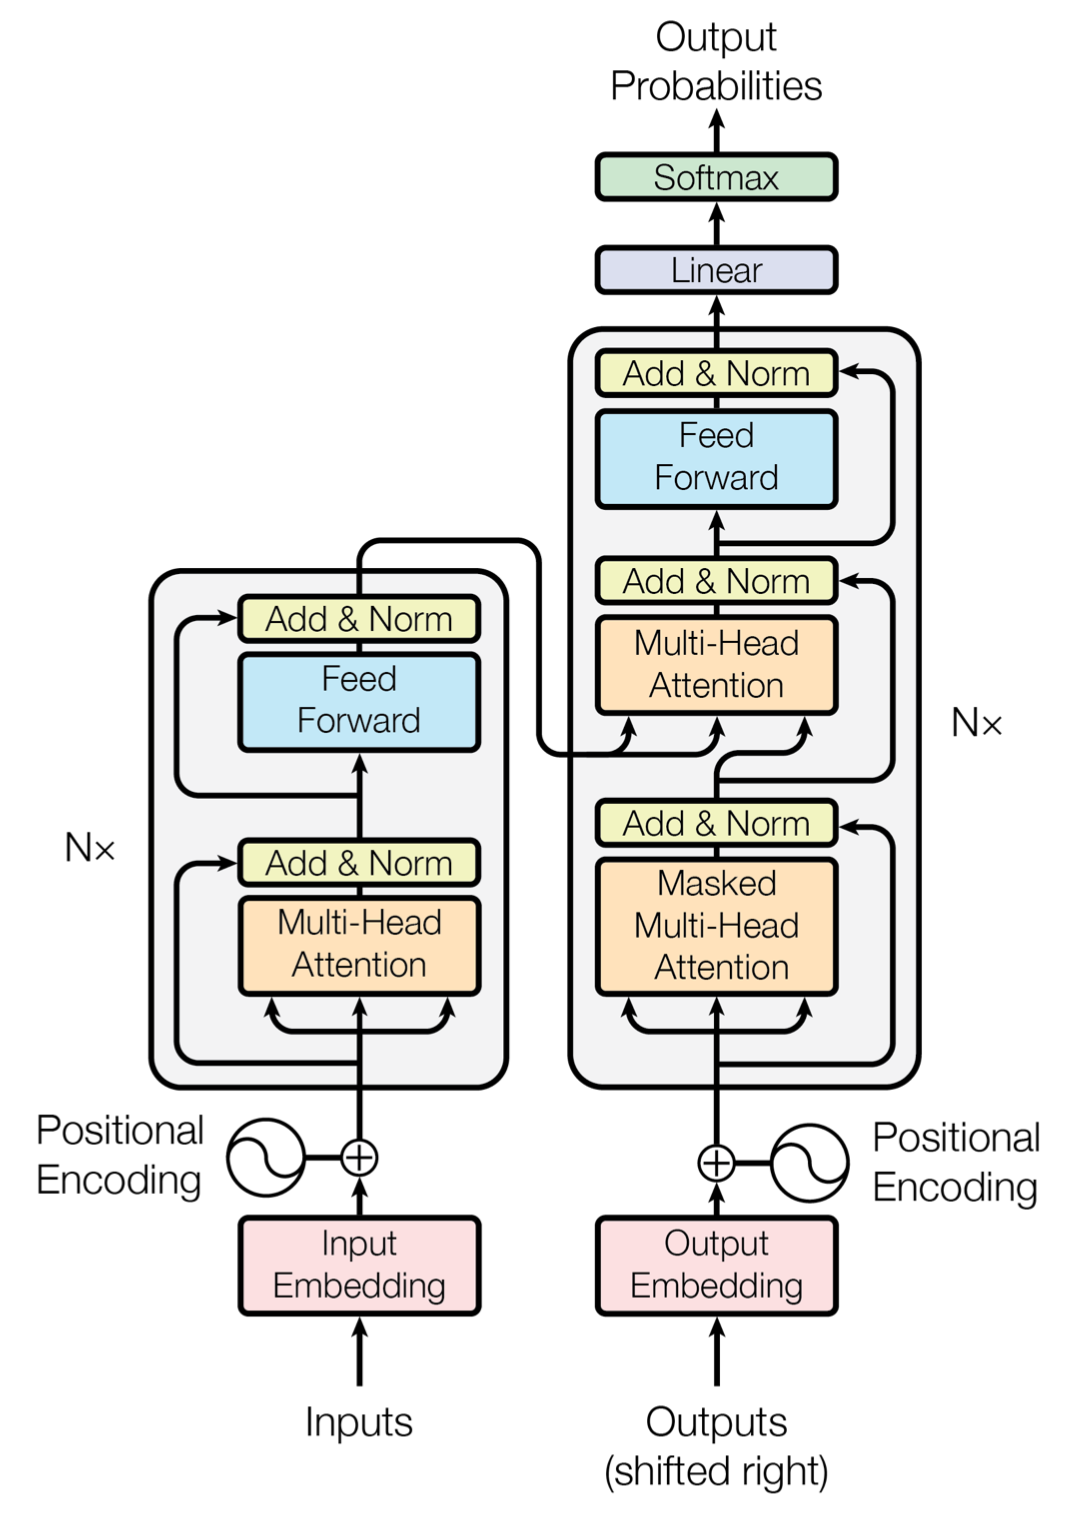

In [1]:
! mkdir -p ~/aiffel/GoingDeeper/DATA/transformer

In [2]:
#- 나눔글꼴 설치 (한국어 시각화를 위한 준비)
! sudo apt -qq -y install fonts-nanum

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBacked.figure_format = 'retina'

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

- Tensor로 변환한 입력 데이터가 주어졌다고 가정할 때, 최초의 텍스트 입력 데이터는 [batch_size x length]의 형태를 가지고 있을 것입니다. 
- 번역이 끝나고 난 최종 출력 데이터는 [batch_size x length x vocab_size]의 형태를 가지게 됩니다. 
- 번역문제는 결국 매 스텝마다 vocab_size 만큼의 클래스 개수 중에 적당한 단어를 선택하는 작업을 length 만큼 반복하는 것입니다. 
- 모델 구성 과정에서 레이어를 통과할 때마다 텐서의 shape이 어떻게 바뀌는지 살펴봅니다.
1. 입력 데이터 -> [batch_size x length]
2. source & target Embedding -> [batch_size x length x d_emb]
3. **Positional Encoding** -> 2번의 결과에 더해지므로 shape 변화는 없습니다.
4. **Multi-Head Attention**
    1) **Split Heads** -> [batch_size x length x heads x (d_emb / n_heads)]
    2) **Making for Masked Attention**
    3) **Scaled Dot Product Attention**
    4) **Combine Heads** -> [batch_size x length x d_emb]
5. Residual Connection
6. Layer Normalization
7. **Position-wise Feed-Forward Network** -> [batch_size x length x d_ff]
8. Output Linear Layer -> [batch_size x length x vocab_size]

- 위에서 굵게 표시된 모듈을 제외하면, 나머지는 텐서플로우 내부에 이미 구현체가 포함되어 있어서 간단히 사용할 수 있습니다. 

# 1. 내부 모듈 구현하기

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn #- Attention 시각화

print(tf.__version__)

2.4.1


### Positional Encoding
- 문장의 연속성을 부여하는 새로운 방법입니다.
- 주어진 시퀀스에서 특정한 위치에 대한 유한한 차원의 representation입니다. 
- transformerd에서 입력시퀀스의 각 원소별 임베딩결과와 positional encoding 결과가 더해져야 하므로 positional encoding의 결과는 [시퀀스의 길이, 임베딩 차원]크기를 가져야만 합니다. 
- 1. simple indexing(absolute positional encoding)
    - 각 단어에 선형적으로 증가하는 정수를 더한다.
    - 단어 간의 거리(Delta)가 일정해지는 것은 좋지만 범위가 무제한이기 때문에 값이 매우 커질 수 있고 모델이 일반화하기 어려워진다.
- 2. normalize simple indexing
    - 각 단어에 0-1 사이의 값을 더한다.
    - 문장의 길이에 따라 더해지는 값이 가변적이기 때문에 단어 간의 거리가 일정하지 않다.
- 3. Using binary
    - 인덱스 값 자체를 이진수(0,1)로 표현합니다. 
    - 하지만 우리는 연속적인 벡터로부터 임의의 위치 값을 얻고 싶은데, 이 방법은 순수히 discrete 합니다.
- 4. Continuous binary vector
    - 위 이진 벡터를 연속적으로 만들기 위해서는 0과 1을 오가는 함수가 필요합니다. => sine 함수
    - 특히 sine 함수는 [-1,1] 사이에 값이 위치해 있으므로 정규화가 되어 있습니다. 
    - 특정 시퀀스의 위치를 해당 위치에 존재하는 d_model개의 0-1을 조절하여 표현할 수 있습니다. 
    - 이때 positional encoding의 결과가 이진 벡터일 필요가 없기 때문에, 주기가 굳이 ${\pi \over 2}$로부터 파생될 필요가 없고, 단지 j에 따라서 주파수가 감소하면 됩니다. 
    - 따라서 transformer에서는 최저 frequency $w_0 = {1 \over 10000}$으로 j가 증가할 때마다 주파수가 단조적으로 감소합니다. 
    
- positional encoding이 만족해야할 4가지 조건
    1. 각 time-step마다 고유의 encoding 값을 출력해야 합니다. 
    2. 서로 다른 time-step이라도 같은 거리라면 차이가 일정해야 합니다. 
    3. 순서를 나타내는 값이 특정 범위 내에서 일반화가 가능해야 합니다. 
    4. 같은 위치라면 언제든 같은 값을 출력해야 합니다.
- 저자들은 Sinusoid Embedding(사인파 임베딩)을 제안합니다.
$$PE_{pos,2i} = sin(pos/10000^{2i/d_{model}})$$
$$PE_{pos,2i+1} = cos(pos/10000^{2i/d_{model}})$$
- pos : 단어가 위치한 time-step  
- i : encoding 차원의 index
- d_model : 모델의 embedding 차원 수

- 참고: [positiona encoding에서 왜  sine함수를 사용할까?](https://hongl.tistory.com/231)
---

- [:, 0::2]는 전체 행 중에서 '인덱스 0부터 끝까지 2칸 간격'의 열을 가리킵니다. 0,2,4,6 .. 과 같이 짝수번째 열이 포함됩니다. 
- sinusoid_table에서 짝수번째 열은 sin함수를, 홀수번째열은 cos함수를 적용합니다.  


In [5]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position,i)for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:,0::2]) 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:,1::2])
    
    return sinusoid_table

pos = 7 
d_model = 4
i = 0

print("Positional Encoding 값: \n", positional_encoding(pos, d_model))

print("")
print("if pos==0, i==0:", np.sin(0/np.power(10000,2*i/d_model)))
print("if pos==1, i==0:", np.sin(1/np.power(10000,2*i/d_model)))
print("if pos==2, i==0:", np.sin(2/np.power(10000,2*i/d_model)))
print("if pos==3, i==0:", np.sin(3/np.power(10000,2*i/d_model)))

print("")
print("if pos==0, i==1:", np.cos(0/np.power(10000,2*i+1/d_model)))
print("if pos==1, i==1:", np.cos(1/np.power(10000,2*i+1/d_model)))
print("if pos==2, i==1:", np.cos(2/np.power(10000,2*i+1/d_model)))
print("if pos==3, i==1:", np.cos(3/np.power(10000,2*i+1/d_model)))

Positional Encoding 값: 
 [[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.99500417  0.00999983  0.9999995 ]
 [ 0.90929743  0.98006658  0.01999867  0.999998  ]
 [ 0.14112001  0.95533649  0.0299955   0.9999955 ]
 [-0.7568025   0.92106099  0.03998933  0.999992  ]
 [-0.95892427  0.87758256  0.04997917  0.9999875 ]
 [-0.2794155   0.82533561  0.05996401  0.999982  ]]

if pos==0, i==0: 0.0
if pos==1, i==0: 0.8414709848078965
if pos==2, i==0: 0.9092974268256817
if pos==3, i==0: 0.1411200080598672

if pos==0, i==1: 1.0
if pos==1, i==1: 0.9950041652780258
if pos==2, i==1: 0.9800665778412416
if pos==3, i==1: 0.955336489125606


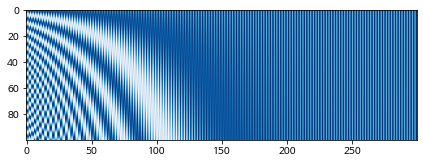

In [6]:
plt.figure(figsize=(7,7))
plt.imshow(positional_encoding(100,300), cmap='Blues')
plt.show()

### Multi-Head Attention
- Multi-Head Attention은 여러 개의 서브 모듈을 결합하여 완성합니다. 
    - Embedding된 입력을 Head 수로 분할하는 split_heads()
    - 분할된 입력으로부터 Attention 값을 구하는 scaled_dot_product_attention()
    - 연산이 종료되고 분할된 Head를 다시 하나로 결합시켜주는 combine_heads()
- Masking에서 마스크의 형태를 결정하는 것은 모델 외부의 훈련 데이터이기 때문에, 이를 생성하는 함수는 MultiheadAttention의 외부에서 정의해줍니다. 

In [8]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
       
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

### Position-wise Feed-Forward Network
- d_ff 는 2048, d_model 은 512입니다.
- [ batch x length x d_model ] 의 입력을 받아 w_1 이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후, 다시 w_2 를 통해 512차원으로 되돌립니다. 

In [9]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)
        
    def call(self,x):
        out = self.w_1(x)
        out = self.w_2(out)
        
        return out

# 2. 모듈 조립하기

### Encoder Layer
- Transformer는 많은 실험을 통해 탄생한 모델입니다. 
- 레이어 수를 원하는 만큼 쌓아 실험을 자유로이 할 수 있으려면, 모델이 동적으로 완성될 수 있어야 합니다.
- tf.keras.layers.Layer클래스를 상속받아 레이어 클래스를 정의해주면 됩니다. 

- Transformer의 구현에서 Normalization Layer의 위치에 대한 논의가 종종 나옵니다.
- 실제 논문에서는 [Input] - [Module] - [Residual] - [Norm] (Module = MHA, FFN)으로 표현되어 있지만, Official 구현인 구글의 Tensor2Tensor에서는  [Input] - [Norm] - [Module] - [Residual] 의 방식을 사용했습니다. 

- 레이어가 많아질수록 후자가 약간 더 좋은 성능을 보였기에 논문 대신 Official 구현을 따르길 추천합니다.
- [On Layer Normalization in the Transformer Architecture](https://arxiv.org/pdf/2002.04745.pdf)에서는 모듈 앞에 Normalization Layer를 두는 pre-LN 방식이 왜 유리한지 설명합니다. 

In [10]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn
    

### Decoder Layer


In [11]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
            
        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
            
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
            
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
            
        self.dropout = tf.keras.layers.Dropout(dropout)
            
    def call(self, x, enc_out, causality_mask, padding_mask):
        """
        Masked Multi-Head Attention
        """
        
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Multi-Head Attention
        """
        
        residual = out 
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, dec_attn, dec_enc_attn

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns


In [13]:
class Decoder(tf.keras.Model):
    def __init__(self,
                n_layers,
                d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout)
                          for _ in range(n_layers)]
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        
        dec_attns = list()
        dec_enc_attns = list()
        
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            

In [14]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns


# 3. 모델 밖의 조력자들
- 모델 외적인 부분인 **Masking 과 Learning Rate**을 정의해주겠습니다

## Masking
- generate_padding_mask() 는 Attention을 할 때에 \<PAD\> 토큰에도 Attention을 주는 것을 방지해 주는 역할을 합니다. 한 배치의 데이터에서 \<PAD\> 토큰으로 이뤄진 부분을 모두 찾아내는 마스크를 생성합니다

In [15]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

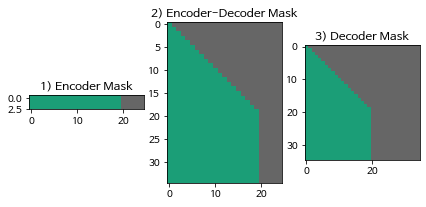

In [16]:
#- generate_padding_mask() 확인하기 

import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

- 첫 번째 마스크는 각 배치 별로 데이터의 꼬리 부분을 Masking 하는 형태임을 알 수 있습니다. 
- 두 번째와 세 번째의 Decoder가 연관된 마스크는 Causality Mask와 Padding Mask를 결합한 형태입니다. 
- 자기 회귀적인 특성을 살리기 위해서 masked multi-head attention에서 인과관계 마스킹을 했었습니다. 인과 관계를 가리는 것도 중요하지만, Decoder역시 \<PAD\> 토큰은 피해가야 하기 때문에 이러한 형태의 마스크가 사용됩니다. 

## Learning Rate
- 이전에는 numpy 로 간단히 구현했었지만, 이번에는 Tensorflow 상에서 잘 구동될 수 있도록 LearningRateSchedule 클래스를 상속받아 구현해보겠습니다.
- 가변적인 Learning Rate를 구현하는 방법입니다. 
- Optimizer는 논문에 정의된 대로 Adam Optimizer를 사용하며 세부 파라미터도 동일하게 맞춰 줍니다.

In [17]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)
